In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import re
import nltk
import kagglehub
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model
import pickle




In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')

Using Colab cache for faster access to the 'twitter-entity-sentiment-analysis' dataset.
Data source import complete.


In [4]:
print("Dataset path:", jp797498e_twitter_entity_sentiment_analysis_path)
print(os.listdir(jp797498e_twitter_entity_sentiment_analysis_path))


Dataset path: /kaggle/input/twitter-entity-sentiment-analysis
['twitter_validation.csv', 'twitter_training.csv']


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
train_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv'
train_df = pd.read_csv(train_path, header=None)
val_path = '/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv'
val_df = pd.read_csv(val_path, header=None)

In [7]:
train_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
train_df.columns = ['tweet_id', 'entity', 'sentiment', 'text']
val_df.columns = ['tweet_id', 'entity', 'sentiment', 'text']

In [9]:
train_df.head()

,tweet_id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [10]:
train_df['entity'].unique()

array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [11]:
train_df['text'] = train_df['text'].fillna('').astype(str)
val_df['text'] = val_df['text'].fillna('').astype(str)

In [12]:
train_df.isna().sum()

,0
tweet_id,0
entity,0
sentiment,0
text,0


In [13]:
def clean_tweet(tweet):
  tweet = re.sub(r'http\S+', '', tweet)
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
  tweet = re.sub(r'[^\w\s]', '', tweet)
  tweet = tweet.lower()
  return tweet
stop_words = set(stopwords.words('english'))
train_df['clean_text'] = train_df['text'].apply(clean_tweet)
train_df['clean_text'] = train_df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
val_df['clean_text'] = val_df['text'].apply(clean_tweet)
val_df['clean_text'] = val_df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))



In [14]:
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [15]:
train_df['sentiment'].value_counts()


,count
sentiment,
Negative,22542
Positive,20832
Neutral,18318
Irrelevant,12990


In [16]:
train_df = train_df[train_df['sentiment']!='Irrelevant']
val_df = val_df[val_df['sentiment']!='Irrelevant']

In [17]:
train_df['sentiment'] = train_df['sentiment'].str.lower()
val_df['sentiment'] = val_df['sentiment'].str.lower()


In [18]:
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_df['label'] = train_df['sentiment'].map(label_map)
val_df['label'] = val_df['sentiment'].map(label_map)


In [19]:
print(train_df['label'].unique())

[2 1 0]


In [20]:
train_df.drop(['tweet_id', 'entity', 'sentiment'], axis=1, inplace=True)
val_df.drop(['tweet_id', 'entity', 'sentiment'], axis=1, inplace=True)

In [21]:
Max_words = 10000
Max_len = 50
tokenizer = Tokenizer(num_words=Max_words)
tokenizer.fit_on_texts(train_df['clean_text'])
train_sequences = tokenizer.texts_to_sequences(train_df['clean_text'])
val_sequences = tokenizer.texts_to_sequences(val_df['clean_text'])
x_train = pad_sequences(train_sequences, maxlen=Max_len)
x_val = pad_sequences(val_sequences, maxlen=Max_len)
y_train=to_categorical(train_df['label'])
y_val=to_categorical(val_df['label'])


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

model = Sequential([
    Embedding(input_dim=Max_words, output_dim=128, input_length=Max_len),
Dropout(0.3),
    SimpleRNN(units=128,dropout=0.3,return_sequences=False),
    Dense(64,activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
    ])
model.compile(optimizer = 'adamw',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=20,                  # الحد الأقصى للتدريب
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5034 - loss: 0.9581
Epoch 1: val_loss improved from inf to 0.33117, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.5035 - loss: 0.9579 - val_accuracy: 0.8829 - val_loss: 0.3312
Epoch 2/20
957/964 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8246 - loss: 0.4473
Epoch 2: val_loss improved from 0.33117 to 0.21722, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8246 - loss: 0.4472 - val_accuracy: 0.9324 - val_loss: 0.2172
Epoch 3/20
959/964 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8709 - loss: 0.3261
Epoch 3: val_loss improved from 0.21722 to 0.20947, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8709 - loss: 0.3261 - val_accuracy: 0.9324 - val_loss: 0.2095
Epoch 4/20
959/964 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8871 - loss: 0.2823
Epoch 4: val_loss did not improve from 0.20947
964/964 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8871 - loss: 0.2823 - val_accuracy: 0.9287 - val_loss: 0.2237
Epoch 5/20
962/964 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9009 - loss: 0.2429
Epoch 5: val_loss did not improve from 0.20947
964/964 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9009 - loss: 0.2430 - val_accuracy: 0.9287 - val_loss: 0.2464
Epoch 6/20
961/964 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9073 - loss: 0.2273
Epoch 6: val_loss did not improve from 0.20947
964/964 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9073 - loss: 0.2273 - val_accuracy: 0.9408 - val_loss: 0.2253


In [ ]:
loss,acc = model.evaluate(x_val,y_val)
print("Loss:", loss)
print("Accuracy:", acc)


In [ ]:
model.save('best_model1.h5')

In [ ]:
best_model =load_model('best_model1.h5')

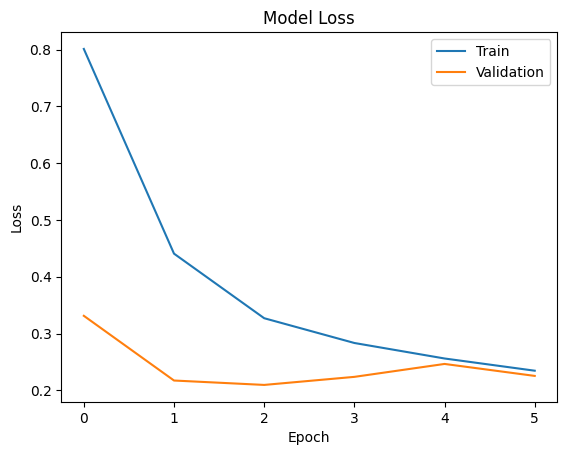

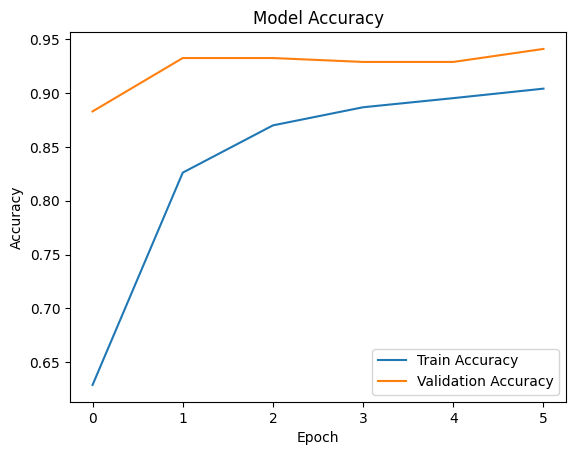

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.plot(history.history['accuracy'],label = "Train Accuracy")
plt.plot(history.history['val_accuracy'],label = "Validation Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
y_pred = best_model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive']))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

    Negative       0.93      0.97      0.95       266
     Neutral       0.93      0.92      0.92       285
    Positive       0.94      0.91      0.92       277

    accuracy                           0.93       828
   macro avg       0.93      0.93      0.93       828
weighted avg       0.93      0.93      0.93       828



In [ ]:
def predict_sentiment(text, tokenizer, model, max_len=Max_len):
    text = clean_tweet(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    class_idx = np.argmax(pred, axis=1)[0]
    label_map_reverse = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return label_map_reverse[class_idx]
predict_sentiment("I love this game!", tokenizer, best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'Positive'

In [ ]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

model = Sequential([
    Embedding(input_dim=Max_words, output_dim=128, input_length=Max_len),
Dropout(0.3),
    LSTM(units=128,dropout=0.3,return_sequences=False),
    Dense(64,activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
    ])
model.compile(optimizer = 'adamw',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20
960/964 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5929 - loss: 0.8582
Epoch 1: val_loss improved from inf to 0.33047, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5934 - loss: 0.8575 - val_accuracy: 0.8877 - val_loss: 0.3305
Epoch 2/20
960/964 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8261 - loss: 0.4409
Epoch 2: val_loss improved from 0.33047 to 0.19825, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8261 - loss: 0.4408 - val_accuracy: 0.9275 - val_loss: 0.1982
Epoch 3/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8726 - loss: 0.3210
Epoch 3: val_loss improved from 0.19825 to 0.19087, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8726 - loss: 0.3210 - val_accuracy: 0.9457 - val_loss: 0.1909
Epoch 4/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8930 - loss: 0.2647
Epoch 4: val_loss improved from 0.19087 to 0.16948, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8930 - loss: 0.2647 - val_accuracy: 0.9408 - val_loss: 0.1695
Epoch 5/20
963/964 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9030 - loss: 0.2306
Epoch 5: val_loss improved from 0.16948 to 0.16498, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9030 - loss: 0.2306 - val_accuracy: 0.9541 - val_loss: 0.1650
Epoch 6/20
962/964 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9113 - loss: 0.2081
Epoch 6: val_loss improved from 0.16498 to 0.15396, saving model to best_model.h5


964/964 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9113 - loss: 0.2081 - val_accuracy: 0.9589 - val_loss: 0.1540
Epoch 7/20
962/964 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9211 - loss: 0.1845
Epoch 7: val_loss did not improve from 0.15396
964/964 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9211 - loss: 0.1845 - val_accuracy: 0.9601 - val_loss: 0.1568
Epoch 8/20
964/964 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9262 - loss: 0.1720
Epoch 8: val_loss did not improve from 0.15396
964/964 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9262 - loss: 0.1720 - val_accuracy: 0.9577 - val_loss: 0.1569
Epoch 9/20
962/964 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9313 - loss: 0.1572
Epoch 9: val_loss did not improve from 0.15396
964/964 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9313 - loss: 0.1573 - val_accuracy: 0.9626 - val_loss: 0.1687


In [24]:
loss, acc = model.evaluate(x_val, y_val)
print("Loss:", loss)
print("Accuracy:", acc)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9558 - loss: 0.1462
Loss: 0.15395872294902802
Accuracy: 0.9589372277259827


In [25]:
model.save('best_lstm_model_final.h5')

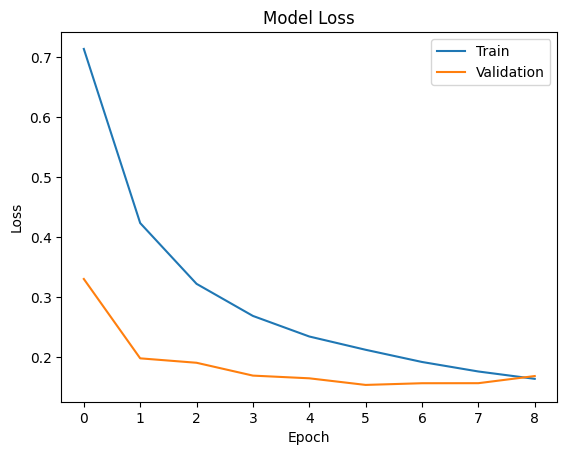

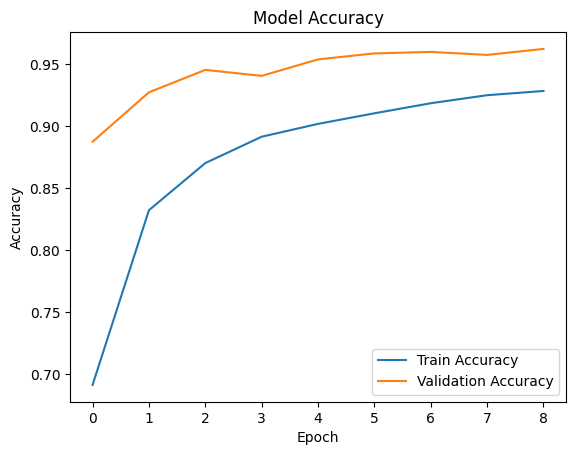

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [32]:
best_model = load_model('best_lstm_model_final.h5')
y_pred = best_model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [58]:
def predict_sentiment(text, tokenizer, model, max_len=Max_len):
    text = clean_tweet(text)
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)
    class_idx = np.argmax(pred, axis=1)[0]
    label_map_reverse = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return label_map_reverse[class_idx]

print(predict_sentiment("happy", tokenizer, best_model))
print(predict_sentiment("sad", tokenizer, best_model))
print(predict_sentiment("I play this game!", tokenizer, best_model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Neutral
